In [1]:
import os
import re

from PIL import Image
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime
import warnings
warnings.filterwarnings("ignore")
import PIL

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

In [2]:
# Sample data read
sunny_dirpath = '../6000_images/c_sunny/'
overcast_dirpath = '../6000_images/c_overcast/'

img_sunny = cv2.imread(sunny_dirpath + 'stereo_centre_1403619592348819.png')
img_overcast = cv2.imread(overcast_dirpath + 'stereo_centre_1403773067908582.png')
img_sunny = cv2.resize(img_sunny, (128,128)) 
img_overcast = cv2.resize(img_overcast, (128,128)) 

img_sunny_rgb = cv2.cvtColor(img_sunny, cv2.COLOR_BGR2RGB)
img_overcast_rgb = cv2.cvtColor(img_overcast, cv2.COLOR_BGR2RGB)

img_sunny_gray = cv2.cvtColor(img_sunny, cv2.COLOR_BGR2GRAY)
img_overcast_gray = cv2.cvtColor(img_overcast, cv2.COLOR_BGR2GRAY)

## Feature Extraction

### Feature 1 - Grayscale hist

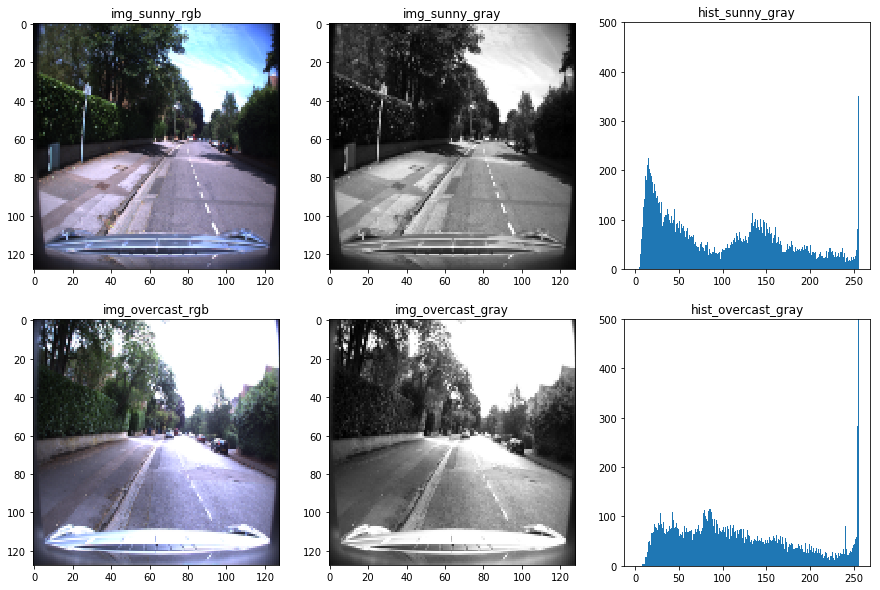

In [3]:
# Raw image and hist visualization
from matplotlib import gridspec

def grayscale_feature_plot():
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)
    ax0 = plt.subplot(gs[0,0])
    ax1 = plt.subplot(gs[0,1])
    ax2 = plt.subplot(gs[0,2])
    ax3 = plt.subplot(gs[1,0])
    ax4 = plt.subplot(gs[1,1])
    ax5 = plt.subplot(gs[1,2])
    # sunny
    ax0.imshow(img_sunny_rgb)
    ax0.set_title('img_sunny_rgb')
    ax1.imshow(img_sunny_gray,cmap='gray')
    ax1.set_title('img_sunny_gray')
    ax2.hist(img_sunny_gray.ravel(),256,[0,256])
    ax2.set_title('hist_sunny_gray')
    ax2.set_ylim([0,500])
    # overcast
    ax3.imshow(img_overcast_rgb)
    ax3.set_title('img_overcast_rgb')
    ax4.imshow(img_overcast_gray,cmap='gray')
    ax4.set_title('img_overcast_gray')
    ax5.hist(img_overcast_gray.ravel(),256,[0,256])
    ax5.set_title('hist_overcast_gray')
    ax5.set_ylim([0,500])
    fig.show()
grayscale_feature_plot()

### Feature 2 - HOG

In [4]:
# HOG feature extract
from skimage.feature import hog
from skimage import data, exposure

In [5]:
# sunny 
fd_sunny, hog_image_sunny = hog(img_sunny_gray, orientations=6, pixels_per_cell=(16, 16), cells_per_block=(1, 1),
                                block_norm='L2', visualise=True)
hog_rescale_sunny = exposure.rescale_intensity(hog_image_sunny, in_range=(0, 10))

# overcast
fd_overcast, hog_image_overcast = hog(img_overcast_gray, orientations=6, pixels_per_cell=(16, 16), cells_per_block=(1, 1), 
                                      block_norm='L2', visualise=True)
hog_rescale_overcast = exposure.rescale_intensity(hog_image_overcast, in_range=(0, 10))

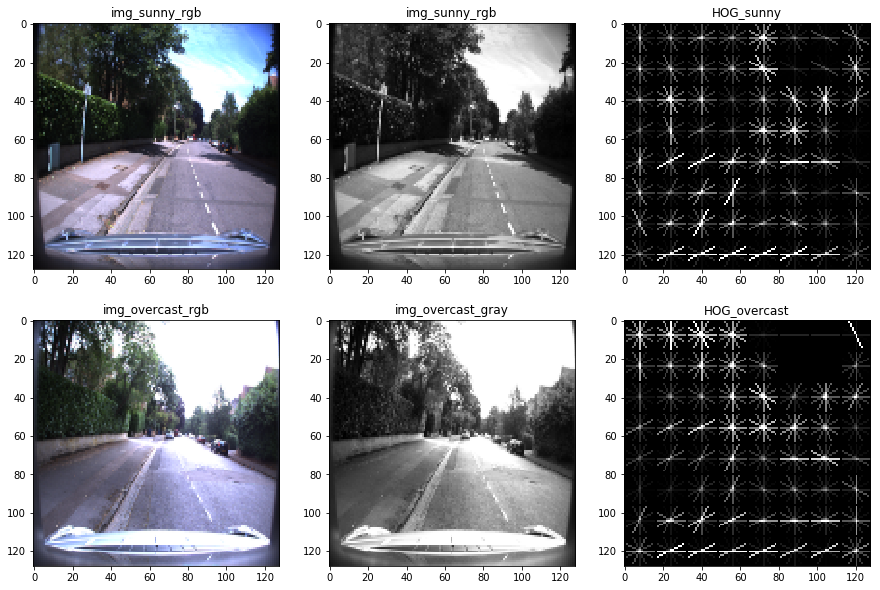

In [7]:
def HOG_feature_plot():
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)
    ax0 = plt.subplot(gs[0,0])
    ax1 = plt.subplot(gs[0,1])
    ax2 = plt.subplot(gs[0,2])
    ax3 = plt.subplot(gs[1,0])
    ax4 = plt.subplot(gs[1,1])
    ax5 = plt.subplot(gs[1,2])
    # sunny
    ax0.imshow(img_sunny_rgb)
    ax0.set_title('img_sunny_rgb')
    ax1.imshow(img_sunny_gray, cmap=plt.cm.gray)
    ax1.set_title('img_sunny_rgb')
    ax2.imshow(hog_rescale_sunny, cmap=plt.cm.gray)
    ax2.set_title('HOG_sunny')

    # overcast
    ax3.imshow(img_overcast_rgb)
    ax3.set_title('img_overcast_rgb')
    ax4.imshow(img_overcast_gray, cmap=plt.cm.gray)
    ax4.set_title('img_overcast_gray')
    #ax3.axis('off')
    ax5.imshow(hog_rescale_overcast, cmap=plt.cm.gray)
    ax5.set_title('HOG_overcast')
    fig.show()
    
HOG_feature_plot()

## Data prepare

In [8]:
sunny_dirpath = '../6000_images/c_sunny/'
overcast_dirpath = '../6000_images/c_overcast/'

In [9]:
# image list
sunny_c = [f for f in os.listdir(sunny_dirpath)]
overcast_c = [f for f in os.listdir(overcast_dirpath)]

### Hist & HOG 6000 images data frame

In [10]:
def resize_cvt2gray(inputpath):
    img = cv2.imread(inputpath)
    img_resize = cv2.resize(img, (128, 128))
    img_gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    return img_gray

In [11]:
# sunny trainning data 
hist_sunny = []
hog_sunny = []
for image in sunny_c:
    img_gray = resize_cvt2gray(sunny_dirpath+image)
    
    hist = cv2.calcHist([img_gray],[0],None,[16],[0,256])
    fd_sunny = hog(img_gray, orientations=6, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2')
    
    hist_sunny.append(hist.ravel())
    hog_sunny.append(fd_sunny)
    
    df_sunny_hist = pd.DataFrame(np.array(hist_sunny))
    df_sunny_hog = pd.DataFrame(np.array(hog_sunny))
    
    df_sunny = pd.DataFrame(np.hstack((df_sunny_hist,df_sunny_hog)))
    df_sunny['label'] = 1

In [12]:
# overcast trainning data 
hist_overcast = []
hog_overcast = []
for image in overcast_c:
    img_gray = resize_cvt2gray(overcast_dirpath+image)
    
    hist = cv2.calcHist([img_gray],[0],None,[16],[0,256])
    fd_overcast = hog(img_gray, orientations=6, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2')
    
    hist_overcast.append(hist.ravel())
    hog_overcast.append(fd_overcast)
    
    df_overcast_hist = pd.DataFrame(np.array(hist_overcast))
    df_overcast_hog = pd.DataFrame(np.array(hog_overcast))
    
    df_overcast = pd.DataFrame(np.hstack((df_overcast_hist,df_overcast_hog)))
    df_overcast['label'] = 0

In [13]:
df_final = pd.concat([df_overcast,df_sunny],ignore_index=True)

In [14]:
df_final.shape

(6000, 401)

## Naive Bayes Classifier

### Label = 1 (Sunny) & Label = 0 (Overcast)

In [15]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [16]:
df_final = shuffle(df_final)
X = df_final.iloc[:,:len(df_final.columns)-1]
y = df_final['label']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [18]:
# Train
clf_nb = GaussianNB()
model = clf_nb.fit(X_train, y_train)

In [19]:
# Test
y_pred = model.predict(X_test)
acc_score = accuracy_score(y_test, y_pred, normalize = True)

Naive Bayes Classifier test accuracy =  0.855


In [20]:
mat = confusion_matrix(y_test, y_pred)
print(mat)

[[863  56]
 [205 676]]


In [22]:
print("Number of mislabeled points out of a total {0} points : {1}".format(len(X_test),(y_test != y_pred).sum()))

Number of mislabeled points out of a total 1800 points : 261
Naive Bayes Classifier test accuracy =  0.855


In [23]:
print("Naive Bayes Classifier test accuracy = ",acc_score)

Naive Bayes Classifier test accuracy =  0.855
